In [632]:
import copy
import pathlib

from astropy.coordinates import SkyCoord
import astropy.table
import astropy.units as u
from astropy.visualization import ImageNormalize, AsymmetricPercentileInterval, LogStretch, AsinhStretch, quantity_support, LinearStretch
from astropy.visualization.wcsaxes import Quadrangle
from astropy.wcs.utils import wcs_to_celestial_frame
import numpy as np
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
import adjustText
from matplotlib.patches import ConnectionPatch
from scipy.interpolate import interp1d
import sunpy.map
import wesanderson
from demcmc import EmissionLine, TempBins, ContFuncDiscrete, predict_dem_emcee

import fiasco
import mocksipipeline
from mocksipipeline.detector.response import Channel, SpectrogramChannel, get_all_dispersed_channels, get_all_filtergram_channels
from mocksipipeline.physics.spectral import SpectralModel
from mocksipipeline.util import stack_components, read_data_cube
from overlappy.io import read_overlappogram
from overlappy.util import color_lat_lon_axes
import synthesizAR
from synthesizAR.interfaces.ebtel import read_xml, run_ebtel
from synthesizAR.instruments.physical import InstrumentDEM

# Figures for MOXSI Poster

Define useful paths here

In [13]:
EBTEL_DIR = pathlib.Path('/Users/wtbarnes/Documents/codes/ebtelPlusPlus/')
sphere_root_dir = pathlib.Path('/Users/wtbarnes/Documents/presentations/talks/sphere-workshop-2023-talk/')
simulation_data_dir = sphere_root_dir / 'pipeline' / 'data'

spd_root_dir = pathlib.Path('/Users/wtbarnes/Documents/presentations/talks/spd-2023-talk/')

root_dir = pathlib.Path('../')
data_dir = root_dir / 'data'
pipeline_dir = root_dir / 'pipeline' / 'data'
figure_directory = pathlib.Path('../src/figures/')

Load list of all relevant spectral lines

In [14]:
line_list = astropy.table.QTable.read(spd_root_dir / 'data' / 'selected_line_list.asdf')

Define useful defaults for plots here

In [15]:
asteroid_city_1 = ["#0A9F9D", "#CEB175", "#E54E21", "#6C8645", "#C18748"]
asteroid_city_2 = ["#C52E19", "#AC9765", "#54D8B1", "#b67c3b", "#175149", "#AF4E24"] 
asteroid_city_3 = ["#FBA72A", "#D3D4D8", "#CB7A5C", "#5785C1"]

In [449]:
frequency_palette = [asteroid_city_3[0], asteroid_city_3[-1]] # wesanderson.color_palettes['The French Dispatch'][0][2:]
spectral_palette = asteroid_city_1 #wesanderson.color_palettes['Darjeeling Limited'][0]
filtergram_palette = asteroid_city_3 #wesanderson.color_palettes['Moonrise Kingdom'][2]

In [17]:
element_colors = {el: color for el,color in zip(np.unique(line_list['element']), asteroid_city_2)}

Define some useful functions

In [18]:
def multi_event_simulation(base_config, N, tn, total_energy, duration, offset=0):
    config = copy.deepcopy(base_config)
    events = []
    for i in range(N):
        t_start = i*(tn + duration) + offset
        events.append({'event':{
            'rise_start': t_start,
            'rise_end': t_start + duration/2,
            'decay_start': t_start + duration/2,
            'decay_end': t_start + duration,
            'magnitude': 2*total_energy/N/duration,}})

    config['heating']['events'] = events
    res = run_ebtel(config, EBTEL_DIR)
    res['time'] = u.Quantity(res['time'], 's')
    res['electron_temperature'] = u.Quantity(res['electron_temperature'], 'K')
    res['density'] = u.Quantity(res['density'], 'cm-3')
    if config['calculate_dem']:
        res['dem_temperature'] = res['dem_temperature']*u.K
        delta_logT = np.diff(np.log10(res['dem_temperature'].to_value('K')))[0]
        logT_edge_left = np.log10(res['dem_temperature'].to_value('K')) - delta_logT/2
        logT_edge_right = np.log10(res['dem_temperature'].to_value('K')) + delta_logT/2
        res['dem_temperature_edges'] = 10**np.append(logT_edge_left, logT_edge_right[-1]) * u.K
        res['dem_corona'] = res['dem_corona']*u.Unit('cm-5K-1')
        res['dem_tr'] = res['dem_tr']*u.Unit('cm-5K-1')
        res['em_corona'] = res['dem_corona'] * np.gradient(res['dem_temperature'])
    return res


def add_arrow_from_coords(ax, tail, head, **arrow_kwargs):
    if tail.unit == u.pix:
        transform = 'pixel'
        end_unit = 'pixel'
    else:
        transform = 'world'
        end_unit = 'deg'
    arrow = matplotlib.patches.FancyArrowPatch(tail.to_value(end_unit),
                                               head.to_value(end_unit),
                                               transform=ax.get_transform(transform),
                                               **arrow_kwargs)
    ax.add_patch(arrow)


def compute_intensity(goft, goft_temperature, dem, dem_temperature):
    f_interp = interp1d(dem_temperature.to_value('K'),
                        dem.to_value('cm-5 K-1'),
                        fill_value='extrapolate',
                        axis=1)
    dem_interp = f_interp(goft_temperature.to_value('K')) * u.Unit('cm-5 K-1')
    return np.trapz(dem_interp * goft, goft_temperature, axis=1).mean().to('erg cm-2 s-1')

## Impulsive Heating Example

In [409]:
total_energy = 1e1 # erg cm-3
duration = 200.
L = 40 * u.Mm
config = read_xml(EBTEL_DIR / 'config' / 'ebtel.example.cfg.xml')
config['calculate_dem'] = True
config['dem']['temperature'] = {
    'bins': 40,
    'log_min': 5.5,
    'log_max': 7.5,
}
config['loop_length'] = L.to_value('cm')
config['total_time'] = 1e4
config['heating']['background'] = 1e-6
offset = 3500
res_single = multi_event_simulation(config, 1, 200, total_energy, duration, offset=offset)
res_multi = multi_event_simulation(config, 15, 500, 2*total_energy, duration, offset=0)

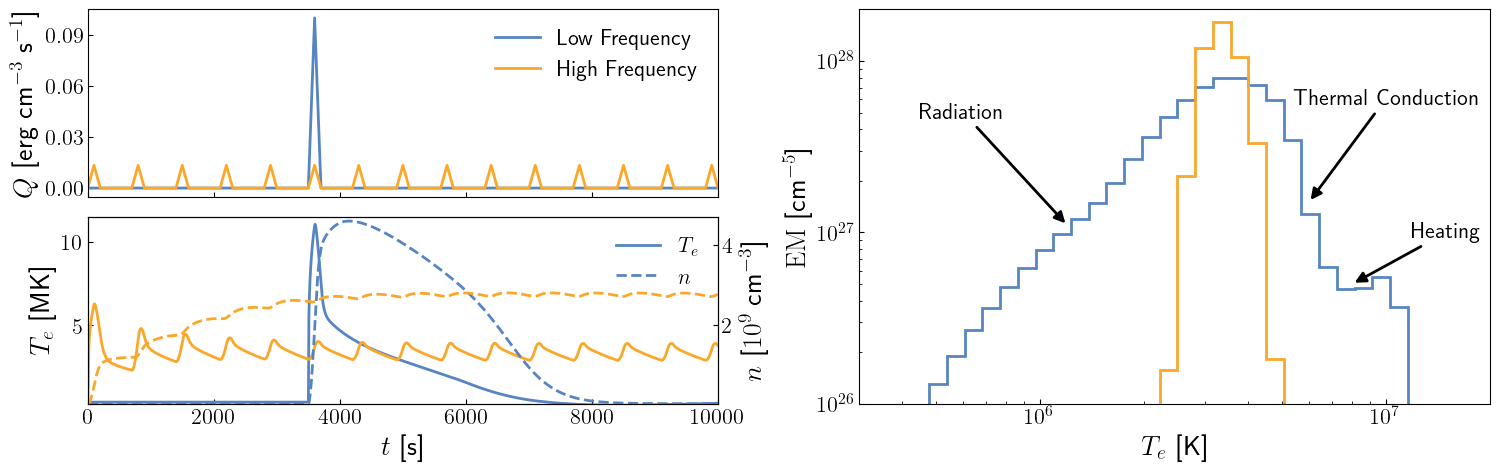

In [444]:
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*(1,4/8),
                 layout='constrained')
axes = fig.subplot_mosaic(
    """
    AC
    BC
    """
)
axB_twin = axes['B'].twinx()

with quantity_support():
    # Plot single nanoflare
    axes['A'].plot(res_single['time'], res_single['heat'], color=frequency_palette[1], label='Low Frequency')
    line_Te = axes['B'].plot(res_single['time'], res_single['electron_temperature'].to(u.MK), color=frequency_palette[1], label='$T_e$')
    line_n = axB_twin.plot(res_single['time'], res_single['density']/1e9, color=frequency_palette[1], ls='--', label='$n$')
    axes['C'].stairs(
        res_single['em_corona'][np.where(np.logical_and(res_single['time']>3500*u.s, res_single['time']<8000*u.s))].mean(axis=0), 
        edges=res_single['dem_temperature_edges'],
        color=frequency_palette[1])
    # Plot multiple nanoflares
    axes['A'].plot(res_multi['time'], res_multi['heat'], color=frequency_palette[0], label='High Frequency')
    axes['B'].plot(res_multi['time'], res_multi['electron_temperature'].to(u.MK), color=frequency_palette[0])
    axB_twin.plot(res_multi['time'], res_multi['density']/1e9, color=frequency_palette[0], ls='--')
    axes['C'].stairs(res_multi['em_corona'].mean(axis=0),
                     edges=res_multi['dem_temperature_edges'], 
                     color=frequency_palette[0])

# Annotate phases
annotate_kwargs = {
    'textcoords': 'data',
    'color': 'k',
    'arrowprops': dict(color='k', arrowstyle='-|>'),
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'rotation': 0,
    'fontsize': plt.rcParams['legend.fontsize'],
}
axes['C'].annotate(f'Heating', xy=(8e6, 5e26), xytext=(1.5e7, 1e27), **annotate_kwargs)
axes['C'].annotate(f'Thermal Conduction', xy=(6e6, 1.5e27),xytext=(1e7, 6e27), **annotate_kwargs)
axes['C'].annotate(f'Radiation', xy=(1.2e6, 1.1e27), xytext=(6e5, 5e27), **annotate_kwargs)

# Labels and limits
axes['A'].set_xlim(0,1e4)
axes['A'].set_ylim(-0.005,0.105)
axes['A'].xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
axes['A'].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=4))
axes['A'].set_ylabel(r'$Q$ [erg cm$^{-3}$ s$^{-1}$]')
axes['A'].legend(frameon=False)
axes['A'].label_outer()

axes['B'].set_xlim(0,1e4)
axes['B'].set_ylim(0.3, 11.5)
axes['B'].set_xlabel(r'$t$ [s]')
axes['B'].set_ylabel(r'$T_e$ [MK]')
axB_twin.set_ylabel(r'$n$ [$10^9$ cm$^{-3}$]')
axB_twin.set_ylim(0.01, 4.7)
axes['B'].legend(lines := line_Te+line_n, [l.get_label() for l in lines], loc=1)


axes['C'].set_xscale('log')
axes['C'].set_yscale('log')
axes['C'].set_ylim(1e26, 2e28)
axes['C'].set_xlim(3e5, 2e7)
axes['C'].set_xlabel(r'$T_e$ [K]')
axes['C'].set_ylabel(r'$\mathrm{EM}$ [cm$^{-5}$]')

fig.savefig(figure_directory / 'impulsive_heating_illustration.pgf')

## DEM Inversions

Run MCMC with only EUV/EIS lines

In [411]:
mcmc_temperature_bins = TempBins(10**np.arange(5.5, 7.3, 0.1) * u.K)

mcmc_cool_lines = []
for row in line_list[line_list['observed by MOXSI']==False]:
    name = f"{row['ion name']}_{row['wavelength']:.3f}"
    eline = EmissionLine(
        cont_func=ContFuncDiscrete(row['contribution function temperature'],
                                   row['contribution function'].to_value('erg cm3 s-1')*u.Unit('cm5 K-1'),
                                   name=name),
        intensity_obs=row['intensity'].to_value('erg cm-2 s-1'),
        sigma_intensity_obs=row['intensity error'].to_value('erg cm-2 s-1'),
        name=name,
    )
    mcmc_cool_lines.append(eline)

dem_result_cool = predict_dem_emcee(mcmc_cool_lines, mcmc_temperature_bins, nwalkers=200, nsteps=3000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:22<00:00, 133.26it/s]


Run MCMC with MOXSI and EIS lines

In [412]:
mcmc_all_lines = []
for row in line_list:
    name = f"{row['ion name']}_{row['wavelength']:.3f}"
    eline = EmissionLine(
        cont_func=ContFuncDiscrete(row['contribution function temperature'],
                                   row['contribution function'].to_value('erg cm3 s-1')*u.Unit('cm5 K-1'),
                                   name=name),
        intensity_obs=row['intensity'].to_value('erg cm-2 s-1'),
        sigma_intensity_obs=row['intensity error'].to_value('erg cm-2 s-1'),
        name=name,
    )
    mcmc_all_lines.append(eline)

dem_result_all = predict_dem_emcee(mcmc_all_lines, mcmc_temperature_bins, nwalkers=200, nsteps=3000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:41<00:00, 72.86it/s]


Plot all DEM results

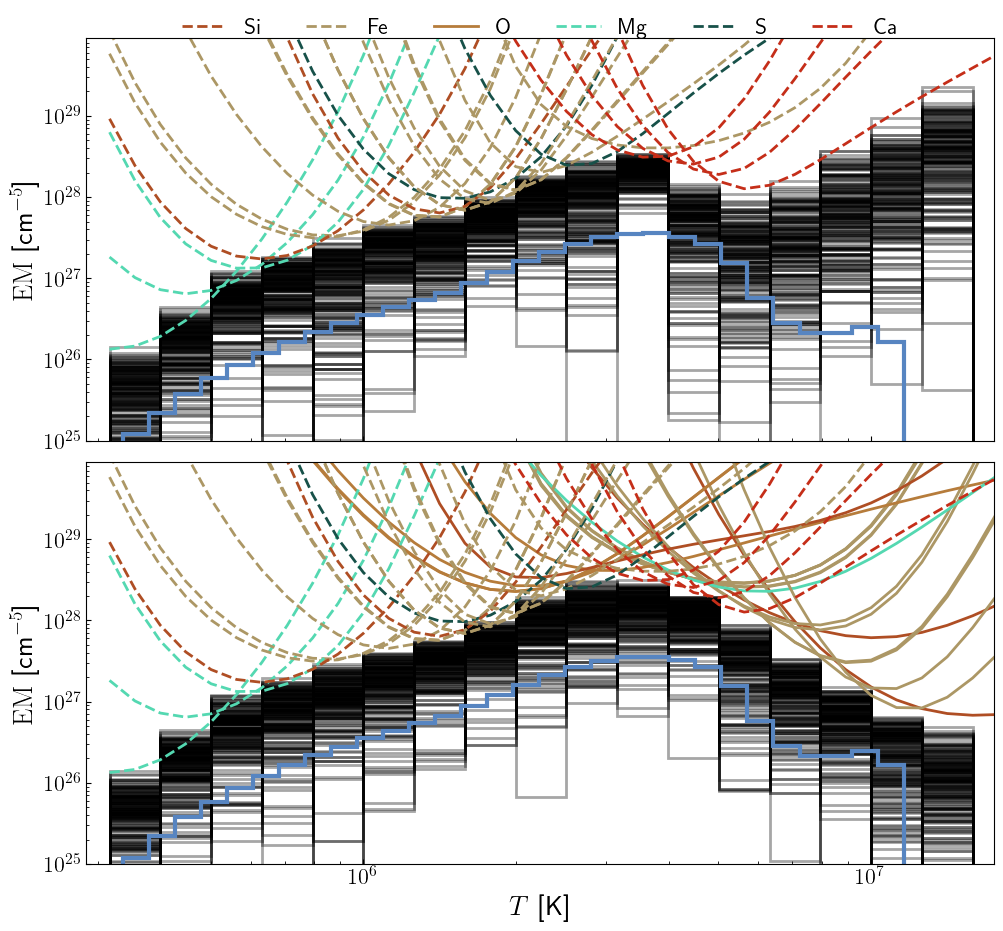

In [995]:
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*(2/3,1), layout='constrained')

axes = fig.subplot_mosaic(
    """
    A
    B
    """,
    sharex=True,
    sharey=True,
)

with quantity_support():
    for sample in dem_result_cool.samples:
        axes['A'].stairs(sample.value*u.Unit('cm-5 K-1')*mcmc_temperature_bins.bin_widths,
                  edges=mcmc_temperature_bins.edges,
                  color='k',
                  alpha=0.35)
    axes['A'].stairs(res_single['em_corona'].mean(axis=0),
              edges=res_single['dem_temperature_edges'],
              color=frequency_palette[1],
              lw=3)
    for row in line_list[line_list['observed by MOXSI']==False]:
        axes['A'].plot(row['contribution function temperature'],
                row['intensity']/row['contribution function'],
                color=element_colors[row['element']],
                label=row['element'],
                ls='--')

    axes['A'].set_xscale("log")
    axes['A'].set_yscale("log")
    axes['A'].set_xlim(mcmc_temperature_bins.min * 0.9, mcmc_temperature_bins.max * 1.1)
    axes['A'].set_ylim(1e25*u.cm**(-5), .9e30*u.cm**(-5))
    axes['A'].set_xlabel('$T$ [K]')
    axes['A'].set_ylabel('$\mathrm{EM}$ [cm$^{-5}$]')

with quantity_support():
    for sample in dem_result_all.samples:
        axes['B'].stairs(sample.value*u.Unit('cm-5 K-1')*mcmc_temperature_bins.bin_widths,
                  edges=mcmc_temperature_bins.edges,
                  color='k',
                  alpha=0.35)
    axes['B'].stairs(res_single['em_corona'].mean(axis=0),
              edges=res_single['dem_temperature_edges'],
              color=frequency_palette[1],
              lw=3)
    for row in line_list:
        axes['B'].plot(row['contribution function temperature'],
                row['intensity']/row['contribution function'],
                color=element_colors[row['element']],
                label=row['element'],
                ls='-' if row['observed by MOXSI'] else '--')
    axes['B'].set_xlabel('$T$ [K]')
    axes['B'].set_ylabel('$\mathrm{EM}$ [cm$^{-5}$]')

legend_entries = dict(zip(*axes['B'].get_legend_handles_labels()[::-1]))

axes['A'].label_outer()
axes['A'].legend(legend_entries.values(), legend_entries.keys(),
                 loc='upper center', ncol=len(legend_entries),
                 bbox_to_anchor=(0.5,1.1))

fig.savefig(figure_directory / 'dem_constraint_comparisons.pgf')

## Line Table

In [993]:
poster_table = moxsi_lines[np.argsort(moxsi_lines['wavelength'])][['element', 'ion name', 'wavelength']]
poster_table['ion name'] = list(map(lambda x: x.split()[1], poster_table['ion name']))
astropy.io.ascii.write(
    poster_table,
    format='latex',
    formats={'Wavelength': '%.3f'},
    names=['Element', 'Ion', 'Wavelength'],
)

\begin{table}
\begin{tabular}{ccc}
Element & Ion & Wavelength \\
 &  & $\mathrm{\mathring{A}}$ \\
Si & XIV & 6.180 \\
Si & XIII & 6.648 \\
Mg & XI & 9.314 \\
Fe & XXI & 12.282 \\
Fe & XX & 12.827 \\
Fe & XIX & 13.525 \\
Fe & XVIII & 14.209 \\
Fe & XIX & 14.669 \\
Fe & XVII & 15.013 \\
Fe & XVII & 15.262 \\
Fe & XVIII & 16.072 \\
Fe & XVII & 16.776 \\
Fe & XVII & 17.051 \\
Fe & XVII & 17.096 \\
O & VIII & 18.967 \\
O & VII & 21.601 \\
O & VII & 21.804 \\
O & VII & 22.098 \\
Si & XII & 44.160 \\
\end{tabular}
\end{table}


## Response Curves

In [418]:
dispersed_channels = get_all_dispersed_channels()[4:]
filtergram_channels = get_all_filtergram_channels()

/Users/wtbarnes/mambaforge/envs/spd-2023-moxsi-talk/lib/python3.11/site-packages/astropy/units/equivalencies.py:143: RuntimeWarning: divide by zero encountered in divide
  (si.m, si.J, lambda x: hc / x),


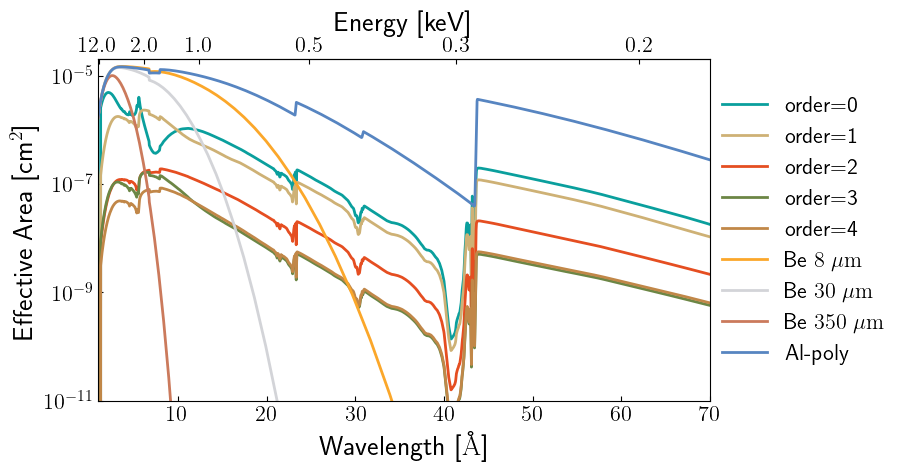

In [996]:
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*(.6,.5), layout='constrained')
ax = fig.add_subplot()
for chan,color in zip(dispersed_channels, spectral_palette):
    ax.plot(chan.wavelength, chan.effective_area, color=color, label=f'order={chan.spectral_order}')
for chan,color in zip(filtergram_channels, filtergram_palette):
    thickness = u.Quantity([f.thickness for f in chan.filters]).sum()
    ax.plot(chan.wavelength, chan.effective_area, color=color,
            label='Al-poly' if 'Al' in chan.filter_label else f'{chan.filters[0].chemical_formula} {thickness.to_string(format="latex_inline")}')

ax.set_yscale('log')
ax.set_xlim(1,70)
ax.set_ylim(1e-11,2e-5)
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')
ax.set_ylabel('Effective Area [cm$^2$]')
wave_to_energy = lambda x: u.Quantity(x, 'AA').to_value('keV', equivalencies=u.equivalencies.spectral())
energy_to_wave = lambda x: u.Quantity(x, 'keV').to_value('AA', equivalencies=u.equivalencies.spectral())
secax = ax.secondary_xaxis('top', functions=(wave_to_energy, energy_to_wave))
secax.set_xlabel('Energy [keV]')
secax.set_xticks([12, 2, 1, 0.5, 0.3, 0.2])
ax.legend(frameon=False,ncol=1, loc='center right', bbox_to_anchor=(1.32,0.5))

fig.savefig(figure_directory / 'effective_areas.pgf')

## Full-disk Overlappograms

In [235]:
moxsi_lines = line_list[line_list['observed by MOXSI']]
moxsi_lines.sort(keys='intensity', reverse=True)

In [236]:
moxsi_line_groups = moxsi_lines.group_by('ion name')

In [26]:
full_disk_sim_dir = pipeline_dir / '2020-11-09T18:00:00_sun_coronal_1992_feldman_ext_all'

In [34]:
dispersed_files = sorted((full_disk_sim_dir / 'dispersed').glob('dispersed_image-order*.fits'))
dispersed_images = [read_overlappogram(f) for f in dispersed_files]
total_dispersed_image = stack_components(dispersed_images, wcs_index=4)

In [242]:
total_dispersed_image_slice = total_dispersed_image[0,150:600,:]

blc = (-150, -700)*u.arcsec
_trc = total_dispersed_image[0].wcs.pixel_to_world(*(np.array(total_dispersed_image[0].data.shape)[::-1]-1))
trc = u.Quantity((300*u.arcsec, _trc.Ty))
hpc_frame = wcs_to_celestial_frame(total_dispersed_image.wcs)
blc_coord = SkyCoord(*blc, frame=hpc_frame)
trc_coord = SkyCoord(*trc, frame=hpc_frame)

iy_lower,ix_lower = total_dispersed_image[0].wcs.world_to_array_index(blc_coord)
iy_upper,ix_upper = total_dispersed_image[0].wcs.world_to_array_index(trc_coord)

iy_lower,iy_upper = np.sort([iy_lower, iy_upper])
ix_lower, ix_upper = np.sort([ix_lower, ix_upper])

In [243]:
total_dispersed_image_cutout = total_dispersed_image[0,iy_lower:iy_upper+1, ix_lower:ix_upper+1]
total_dispersed_image_cutout_spectra = total_dispersed_image_cutout.rebin(
    total_dispersed_image_cutout.data.shape[:1]+(1,),
    operation=np.sum,
)[0,:]

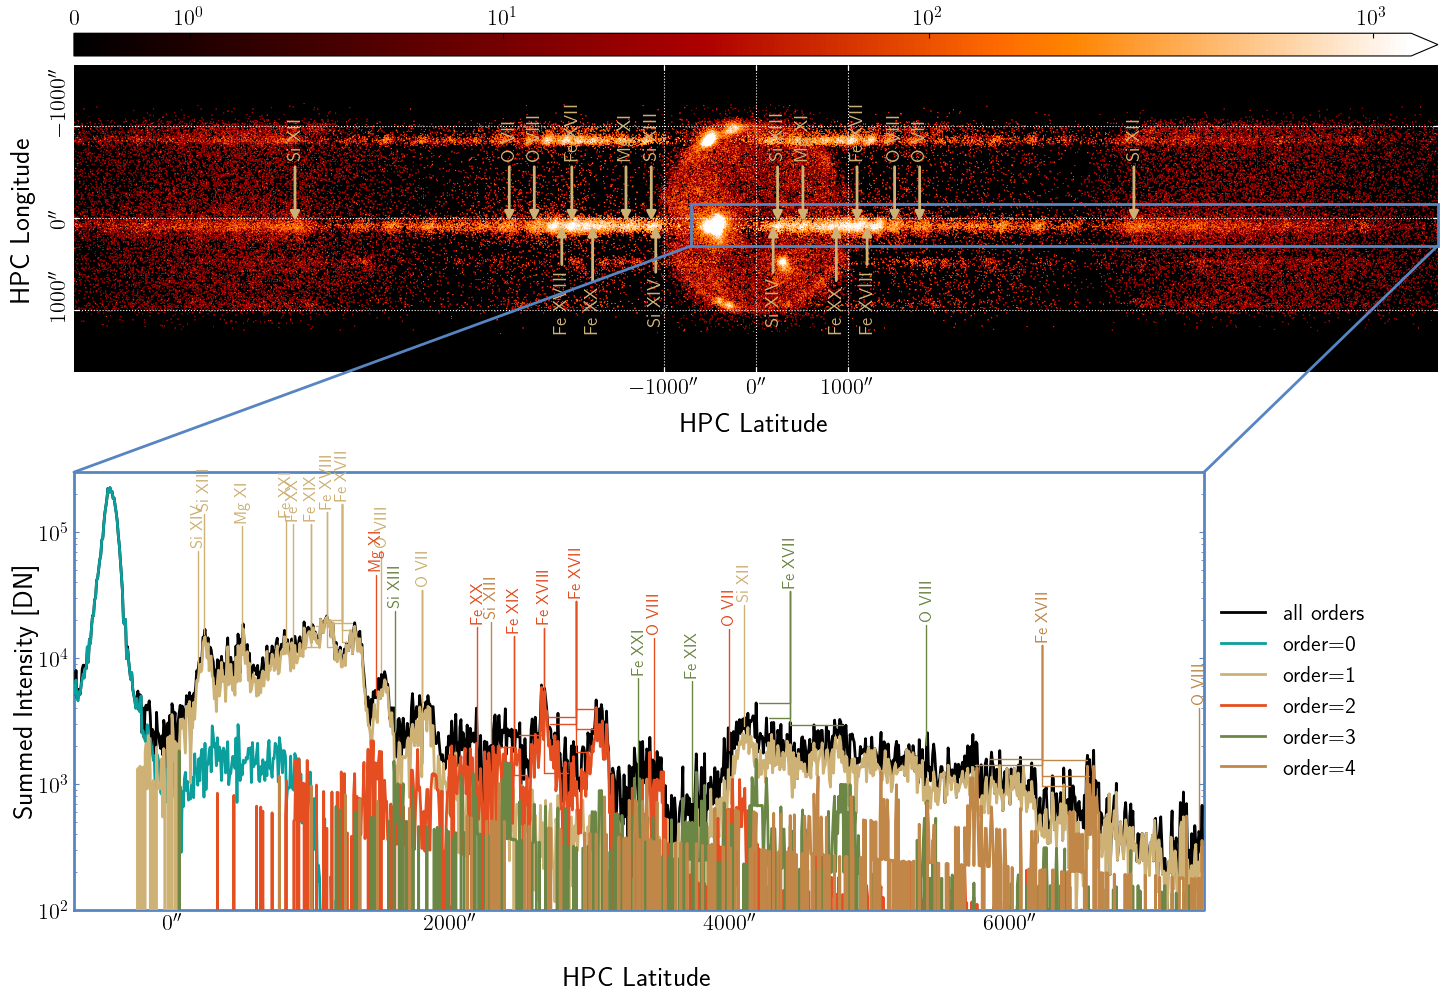

In [458]:
fig = plt.figure()
axes = fig.subplot_mosaic(
    """
    AAAAAA
    BBBBB.
    """,
    per_subplot_kw={
        'A': {'projection': total_dispersed_image_slice},
        'B': {'projection': total_dispersed_image_cutout_spectra}
    }
)

vmin, vmax = AsymmetricPercentileInterval(1, 99.9).get_limits(total_dispersed_image[0].data)
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())

# Overlappogram
total_dispersed_image_slice.plot(axes=axes['A'], norm=norm, cmap='hinodexrt')
color_lat_lon_axes(axes['A'], lon_color='w', lat_color='w')

axes['A'].coords[0].set_ticklabel(rotation=90, color='k')
axes['A'].coords[1].set_ticklabel(color='k')
axes['A'].coords[0].grid(ls=':', color='w')
axes['A'].coords[1].grid(ls=':', color='w')
axes['A'].coords[1].set_axislabel('HPC Longitude', color='k')
axes['A'].coords[0].set_axislabel('HPC Latitude', color='k')
for c in axes['A'].coords:
    c.set_ticks(([-1000,0,1000]*u.arcsec).to('deg'))
    c.set_major_formatter('s')

# Add wavelength annotations
annotate_kw = {
    'textcoords': 'offset points',
    'color': spectral_palette[1],
    'arrowprops': dict(color=spectral_palette[1], arrowstyle='-|>'),
    'horizontalalignment':'center',
    'verticalalignment':'bottom',
    'rotation':90,
    'fontsize': plt.rcParams['xtick.labelsize']*0.85,
    'weight': 'bold',
}
annot_pt = SkyCoord(Tx=60*u.arcsec, Ty=-450*u.arcsec, frame=hpc_frame)
allowed_ions = ['Si XII', 'Si XIII', 'O VII', 'O VIII', 'Fe XVII', 'Mg XI', 'Fe XVIII', 'Si XIV', 'Fe XX']
ypos_mappings = {'Si XIV': -75, 'Fe XX': -80, 'Fe XVIII': -80}
for group in moxsi_line_groups.groups:
    line = group[0]
    if line['ion name'] not in allowed_ions:
        continue
    axes['A'].annotate(
        f'{line["ion name"]}',
        xy=dispersed_images[5][:,150:600,:].wcs.world_to_pixel(annot_pt, line['wavelength'])[:2],
        xytext=(0, ypos_mappings.get(line['ion name'], 45)),
        **annotate_kw
    )
for group in moxsi_line_groups.groups:
    line = group[0]
    if line['ion name'] not in allowed_ions:
        continue
    axes['A'].annotate(
        f'{line["ion name"]}',
        xy=dispersed_images[0][:,150:600,:].wcs.world_to_pixel(annot_pt, line['wavelength'])[:2],
        xytext=(0, ypos_mappings.get(line['ion name'], 45)),
        **annotate_kw
    )

# FOV
cutout = Quadrangle(
    blc,
    trc[0]-blc[0],
    trc[1]-blc[1],
    edgecolor=asteroid_city_3[-1],
    facecolor='none',
    transform=axes['A'].get_transform('world'),
    clip_on=False,
)
axes['A'].add_patch(cutout)
axes['A'].coords.frame.set_linewidth(0)
axes['A'].set_axisbelow(True)

# Summed cutout
total_dispersed_image_cutout_spectra.plot(axes=axes['B'], color='k', label='all orders')
for i,(di,color) in enumerate(zip(dispersed_images[4:],spectral_palette)):
    di_cutout = di[0,iy_lower:iy_upper+1, ix_lower:ix_upper+1]
    di_spectra = di_cutout.rebin(di_cutout.data.shape[:1]+(1,), operation=np.sum)[0,:]
    di_spectra.plot(axes=axes['B'], color=color, label=f'order={i}')
    if i == 0:
        continue
    line_strength_thresh = 0.25
    for group in moxsi_line_groups.groups:
        # Compute average position of all lines in group
        ix_mean = []
        y_mean = []
        for line in group:
            _,_,ix = di[:, iy_lower:iy_upper+1, ix_lower:ix_upper+1].wcs.world_to_array_index(annot_pt, line['wavelength'])
            if ix>total_dispersed_image_cutout_spectra.data.shape[0]-1:
                continue
            if di_spectra.data[ix] / total_dispersed_image_cutout_spectra.data[ix] < line_strength_thresh:
                continue
            ix_mean.append(ix)
            y_mean.append(total_dispersed_image_cutout_spectra.data[ix])
        if len(ix_mean) == 0:
            continue
        ix_mean = np.mean(ix_mean)
        y_mean = np.mean(y_mean)
        ann = axes['B'].annotate(line['ion name'], xy=(ix_mean, y_mean*10),
                                 rotation=90, color=color, va='bottom', ha='center', fontsize=plt.rcParams['xtick.labelsize']*0.75)
        for line in group:
            _,_,ix = di[:, iy_lower:iy_upper+1, ix_lower:ix_upper+1].wcs.world_to_array_index(annot_pt, line['wavelength'])
            if ix>total_dispersed_image_cutout_spectra.data.shape[0]-1:
                continue
            if di_spectra.data[ix] / total_dispersed_image_cutout_spectra.data[ix] < line_strength_thresh:
                continue
            axes['B'].annotate(
                '', #line['ion name'],
                xy=(ix, total_dispersed_image_cutout_spectra.data[ix]),
                xytext=ann.xy,
                textcoords='data',
                arrowprops=dict(arrowstyle='-', color=color, ls='-', connectionstyle='angle,angleA=-90,angleB=180,rad=0', lw=1),
                horizontalalignment='center',
                verticalalignment='center',
                rotation=90,
            )

axes['B'].set_yscale('log')
axes['B'].set_xlim(0,total_dispersed_image_cutout_spectra.data.shape[0])
axes['B'].set_ylim(1e2, 3e5)
axes['B'].coords.frame.set_color(cutout.get_edgecolor())
axes['B'].coords.frame.set_linewidth(2)
for coord in axes['B'].coords:
    coord.set_ticks(color=cutout.get_edgecolor())
axes['B'].coords[1].set_ticklabel(color='k')
axes['B'].yaxis.set_tick_params(color=cutout.get_edgecolor(), which='both')
axes['B'].coords[1].set_axislabel('HPC Latitude', color='k')
axes['B'].set_ylabel('Summed Intensity [DN]')
axes['B'].legend(ncol=1, loc='center right', bbox_to_anchor=(1.16, 0.5))

# Arrows between patch and lower plot
patch_kw = {'axesA': axes['B'], 'axesB': axes['A'], 'arrowstyle': '-', 'color': cutout.get_edgecolor(),}
xpix, ypix = total_dispersed_image_slice.wcs.world_to_pixel(
    SkyCoord(trc_coord.Tx, blc_coord.Ty, frame=trc_coord.frame))
con1 = ConnectionPatch((0, 1), (xpix, ypix), 'axes fraction', 'data', **patch_kw)
xpix, ypix = total_dispersed_image_slice.wcs.world_to_pixel(trc_coord)
con2 = ConnectionPatch((1, 1), (xpix, ypix), 'axes fraction', 'data', **patch_kw)
axes['B'].add_artist(con1)
axes['B'].add_artist(con2)

plt.subplots_adjust(hspace=0.1, left=0.04167, right=1-0.04167, bottom=0, top=1)

fig.colorbar(
    axes['A'].get_images()[0],
    ax=axes['A'],
    orientation='horizontal',
    location='top',
    #fraction=1,
    extend='max',
    extendfrac=0.02,
    format=matplotlib.ticker.LogFormatterMathtext(base=10.0,),
    ticks=[0, 1, 10, 100, 1e3],
    pad=0.02,
    aspect=60
)

fig.savefig(figure_directory / 'full_disk_dispersed_image.pgf')

## Full-disk Filtergrams

In [27]:
filtergram_files = sorted((full_disk_sim_dir / 'filtergram').glob('filtergram_*-order0.fits'))
filtergrams = [read_overlappogram(f) for f in filtergram_files]

In [28]:
cropped_filtergrams = []
for fg in filtergrams:
    hpc_frame = wcs_to_celestial_frame(fg.wcs)
    blc = SkyCoord(Tx=-1200*u.arcsec, Ty=-1200*u.arcsec, frame=hpc_frame)
    trc = SkyCoord(Tx=1200*u.arcsec, Ty=1200*u.arcsec, frame=hpc_frame)
    cropped_filtergrams.append(fg[0].crop(blc, trc))

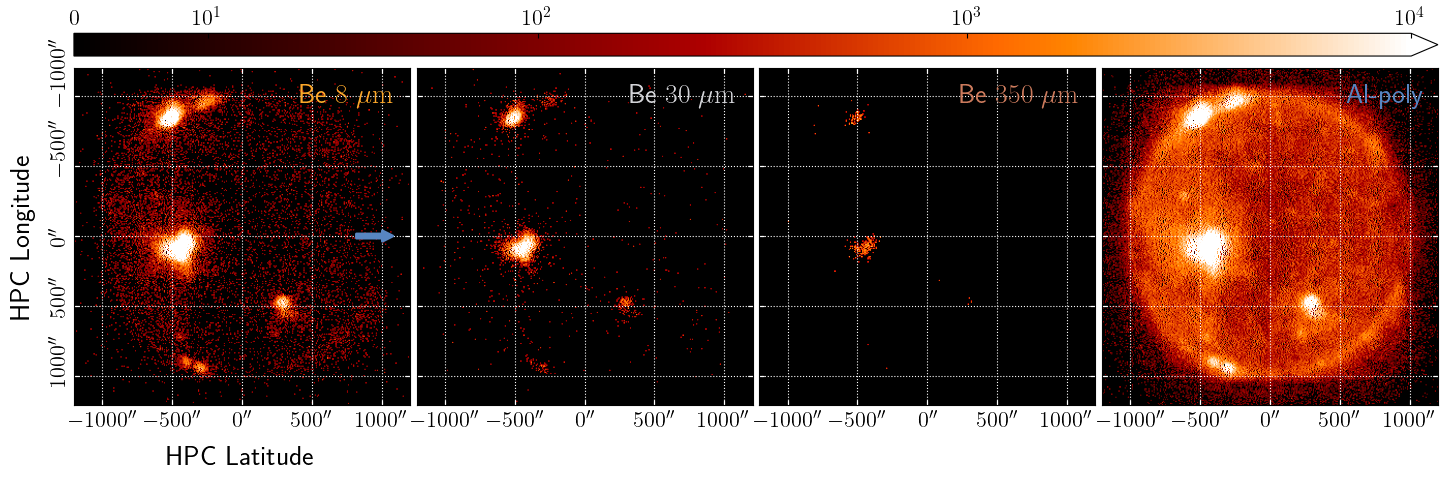

In [456]:
fig = plt.figure(
    figsize=np.array(plt.rcParams['figure.figsize'])*(1,5/8),
    #layout='constrained'
)
axes = fig.subplot_mosaic(
    "ABCD",
    per_subplot_kw={
        'A': {'projection': cropped_filtergrams[0]},
        'B': {'projection': cropped_filtergrams[1]},
        'C': {'projection': cropped_filtergrams[2]},
        'D': {'projection': cropped_filtergrams[3]},
    }
)
norm = ImageNormalize(vmin=0, vmax=10e3, stretch=LogStretch())
for fg,label,chan,color in zip(cropped_filtergrams, ['A','B', 'C', 'D'], filtergram_channels, filtergram_palette):
    fg.plot(axes=axes[label], cmap='hinodexrt', norm=norm)
    color_lat_lon_axes(axes[label], lon_color='w', lat_color='w')
    axes[label].coords[0].set_auto_axislabel(False)
    axes[label].coords[1].set_auto_axislabel(False)
    if label != 'A':
        axes[label].coords[0].set_ticklabel_visible(False)
    else:
        axes[label].coords[0].set_ticklabel(rotation=90, color='k')
    axes[label].coords[1].set_ticklabel(color='k')
    axes[label].coords[0].grid(ls=':', color='w')
    axes[label].coords[1].grid(ls=':', color='w')
    
    thickness = u.Quantity([f.thickness for f in chan.filters]).sum()
    if 'Al' in chan.filter_label:
        filter_label='Al-poly'
    else:
        filter_label = f'{chan.filters[0].chemical_formula} {thickness.to_string(format="latex_inline")}'
    axes[label].text((-1000*u.arcsec).to_value('deg'),
                     (1100*u.arcsec).to_value('deg'),
                     filter_label,
                     color=color,
                     verticalalignment='center',
                     horizontalalignment='right',
                     fontsize=plt.rcParams['axes.labelsize'],
                     transform=axes[label].get_transform('world'))

axes['A'].coords[1].set_axislabel('HPC Longitude', color='k')
axes['A'].coords[0].set_axislabel('HPC Latitude', color='k')

add_arrow_from_coords(axes['A'], (0,800)*u.arcsec, (0, 1100)*u.arcsec, color=asteroid_city_3[-1], mutation_scale=15,)

axes['A'].set_axisbelow(True)

plt.subplots_adjust(wspace=0.02, left=0.04167, right=1-0.04167, bottom=0, top=1)

fig.colorbar(
    axes['A'].get_images()[0],
    ax=[axes['A'], axes['B'], axes['C'], axes['D']],
    orientation='horizontal',
    location='top',
    #fraction=1,
    extend='max',
    extendfrac=0.02,
    format=matplotlib.ticker.LogFormatterMathtext(base=10.0,),
    ticks=[0, 10, 100, 1e3, 10e3],
    pad=0.02,
    aspect=60
)
fig.savefig(figure_directory / 'full_disk_filtergrams.pgf')

## Simulations: AR Map and Time Profiles of Simulations

In [478]:
skeleton_hf = synthesizAR.Skeleton.from_asdf(simulation_data_dir / 'p0.3' / 'skeleton.asdf')
skeleton_lf = synthesizAR.Skeleton.from_asdf(simulation_data_dir / 'p0.005' / 'skeleton.asdf')
m_aia = sunpy.map.Map(simulation_data_dir / 'aia_171.fits')
blc_ar = SkyCoord(Tx=-100*u.arcsec, Ty=-525*u.arcsec, frame=m_aia.coordinate_frame)
trc_ar = SkyCoord(Tx=250*u.arcsec, Ty=-325*u.arcsec, frame=m_aia.coordinate_frame)
# This hack is because I moved files up a directory which messed up the path to the results
old_sim_dir = pathlib.Path('/Users/wtbarnes/Documents/presentations/sphere-workshop-2023-talk/pipeline/data')
for loop in skeleton_hf.loops + skeleton_lf.loops:
    loop.model_results_filename = simulation_data_dir / pathlib.Path(loop.model_results_filename).relative_to(old_sim_dir)

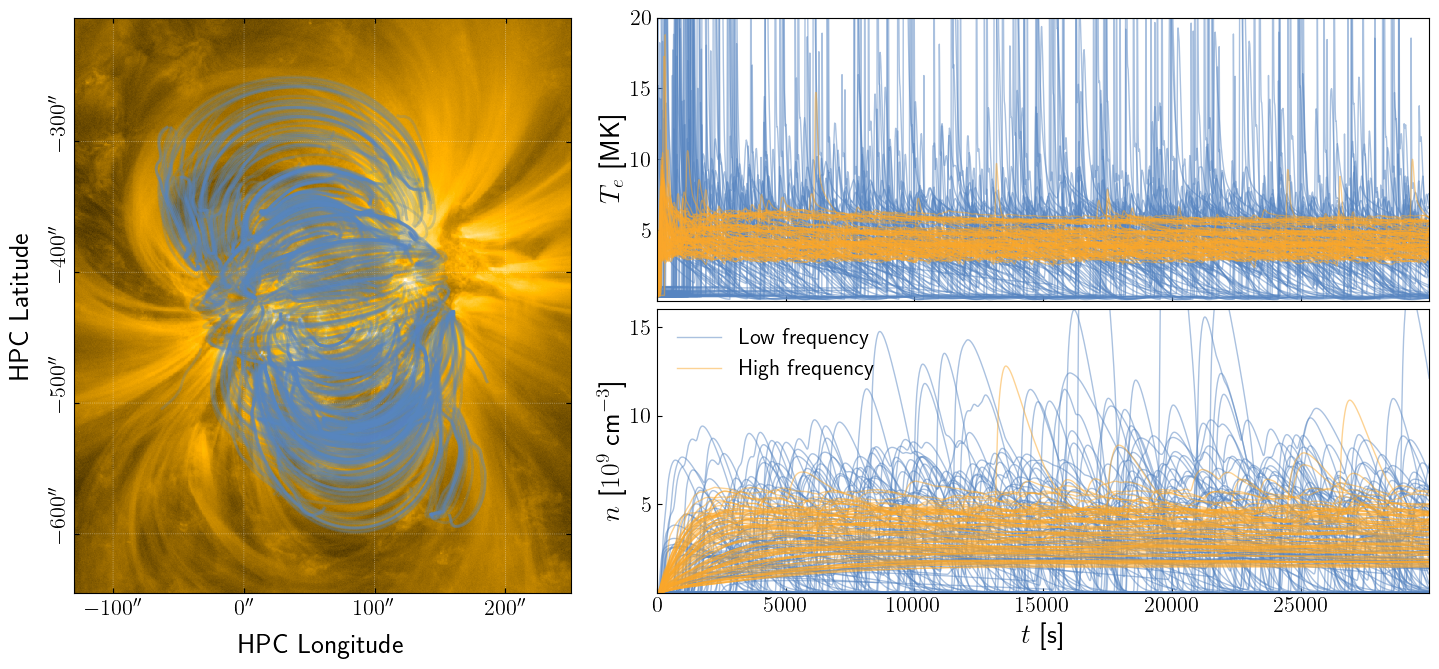

In [519]:
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*(1,5/8))
axes = fig.subplot_mosaic(
    """
    AB
    AC
    """,
    width_ratios=[1,1.5],
    per_subplot_kw={
        'A': {'projection': m_aia},
    },
)

# Fieldlines
m_aia.plot(axes=axes['A'], title=False)
for s in skeleton_hf.loops:
    axes['A'].plot_coord(s.coordinate, color=asteroid_city_3[-1], alpha=0.25)
axes['A'].set_xlim(m_aia.wcs.world_to_pixel(blc_ar)[0]-50, m_aia.wcs.world_to_pixel(trc_ar)[0])
axes['A'].set_ylim(m_aia.wcs.world_to_pixel(blc_ar)[1]-200, m_aia.wcs.world_to_pixel(trc_ar)[1]+200)
axes['A'].coords[0].set_axislabel('HPC Longitude')
axes['A'].coords[1].set_axislabel('HPC Latitude')
axes['A'].coords[1].set_ticklabel(rotation=90)

alpha = 0.5
for i, l in enumerate(skeleton_lf.loops[::10]):
    axes['B'].plot(l.time, l.electron_temperature[:,0].to('MK'), color=frequency_palette[1], alpha=alpha, lw=1)
    line_lf, = axes['C'].plot(l.time, l.density[:,0].to('cm-3')/1e9, color=frequency_palette[1], alpha=alpha, lw=1)
for i, l in enumerate(skeleton_hf.loops[::10]):
    axes['B'].plot(l.time, l.electron_temperature[:,0].to('MK'), color=frequency_palette[0], alpha=alpha, lw=1)
    line_hf, = axes['C'].plot(l.time, l.density[:,0].to('cm-3')/1e9, color=frequency_palette[0], alpha=alpha, lw=1)

axes['B'].set_xlim(skeleton_lf.loops[0].time[[0,-1]].to_value('s'))
axes['C'].set_xlim(skeleton_lf.loops[0].time[[0,-1]].to_value('s'))
axes['B'].set_ylim(1e-4, 20)
axes['C'].set_ylim(1e-5, 16)
axes['C'].set_xlabel('$t$ [s]')
axes['B'].set_ylabel('$T_e$ [MK]')
axes['C'].set_ylabel('$n$ [$10^9$ cm$^{-3}$]')
axes['B'].xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
axes['C'].legend([line_lf, line_hf], ['Low frequency', 'High frequency'])

plt.subplots_adjust(hspace=0.03, wspace=0.12, left=0.04167, right=1-0.04167, bottom=0, top=1)

fig.savefig(figure_directory / 'fieldlines_ebtel_results.pgf')

In [999]:
import sunpy
print(sunpy.__version__)
import aiapy
print(aiapy.__version__)

5.0.0
0.7.3


## DEM Results

In [528]:
temperature_bin_edges = 10**np.arange(5.5, 7.6, 0.1) * u.K
temperature_bin_centers = 10**((np.log10(temperature_bin_edges.value)[1:]+np.log10(temperature_bin_edges.value)[:-1])/2)*u.K
dem_cube_hf = InstrumentDEM.dem_maps_list_to_cube(
    sunpy.map.Map(sorted((simulation_data_dir / 'p0.3' / 'dem').glob('m_*_t1800.fits'))),
    temperature_bin_centers,
)
dem_cube_lf = InstrumentDEM.dem_maps_list_to_cube(
    sunpy.map.Map(sorted((simulation_data_dir / 'p0.005' / 'dem').glob('m_*_t1800.fits'))),
    temperature_bin_centers,
)

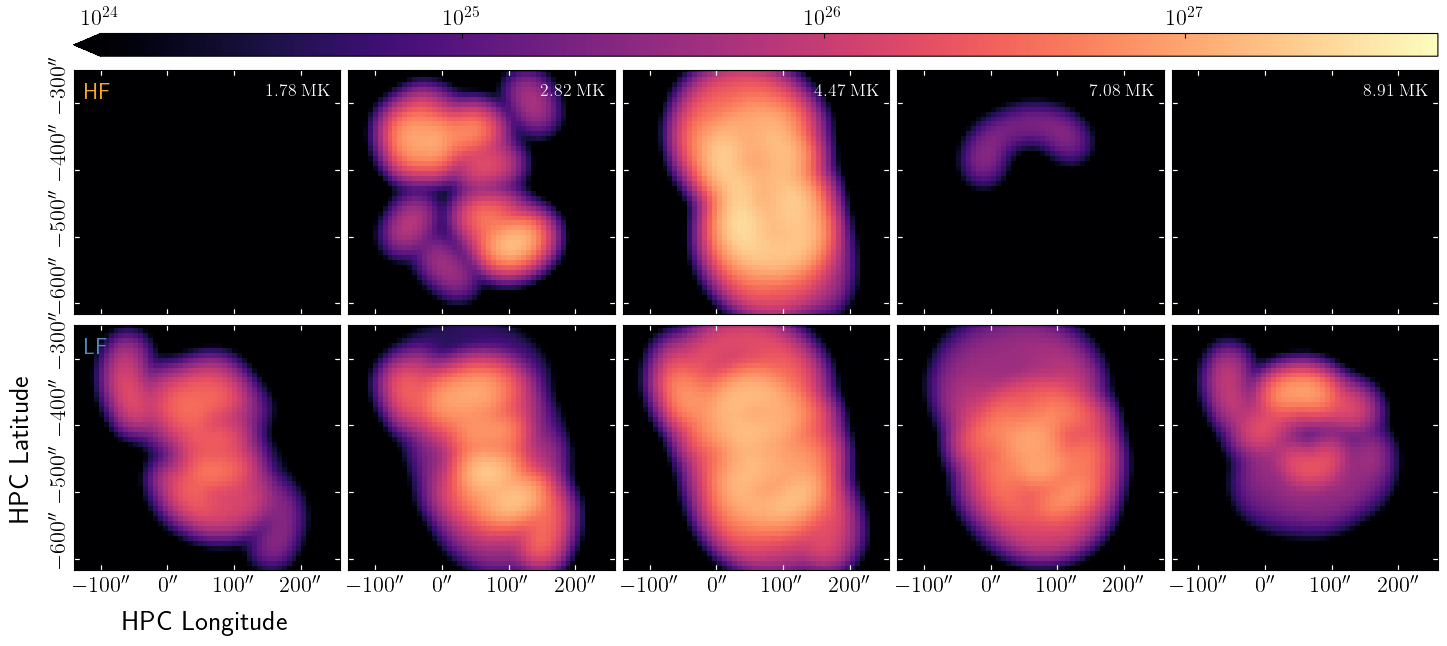

In [1000]:
norm = ImageNormalize(vmin=1e24, vmax=5e27, stretch=LogStretch(5000))
#norm = matplotlib.colors.LogNorm(vmin=1e24, vmax=5e27)
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*(1,0.6))

axes = [
    [fig.add_subplot(2, len(dem_indices), i+1, projection=dem_cube_hf[idem].wcs) for i,idem in enumerate(dem_indices)],
    [fig.add_subplot(2, len(dem_indices), i+len(dem_indices)+1, projection=dem_cube_lf[idem].wcs) for i,idem in enumerate(dem_indices)],
]

dem_indices = [7, 9, 11, 13, 14]
ylim_extent = np.array([0.1,0.85])
# High frequency plots
for i,(ax,dc) in enumerate(zip(axes[0], [dem_cube_hf[idem] for idem in dem_indices])):
    dc.plot(axes=ax, norm=norm, cmap='magma')
    ax.text(
        (245*u.arcsec).to_value('deg'), (-270*u.arcsec).to_value('deg'),
        temperature_bin_centers[dem_indices[i]].to('MK').to_string(format='latex_inline', precision=3),
        transform=ax.get_transform('world'),
        color='w',
        va='top',
        ha='right',
        fontsize=plt.rcParams['legend.fontsize']*0.8,
    )
    ax.coords[0].set_auto_axislabel(False)
    ax.coords[1].set_auto_axislabel(False)
    ax.coords[0].set_ticklabel_visible(False)
    if i > 0:
        ax.coords[1].set_ticklabel_visible(False)
    else:
        ax.coords[1].set_ticklabel(rotation=90, exclude_overlapping=True)
        ax.text(
            (-125*u.arcsec).to_value('deg'), (-270*u.arcsec).to_value('deg'),
            'HF',
            transform=ax.get_transform('world'),
            color=frequency_palette[0],
            va='top',
            ha='left',
            fontsize=plt.rcParams['legend.fontsize'],
        )
    ax.coords[0].set_ticks(color='w')
    ax.coords[1].set_ticks(color='w')
    ax.set_ylim(dem_cube_lf[idem].data.shape[0]*ylim_extent)
# Low frequency plots
for i,(ax,dc) in enumerate(zip(axes[1], [dem_cube_lf[idem] for idem in dem_indices])):
    dc.plot(axes=ax, norm=norm, cmap='magma')
    ax.coords[0].set_auto_axislabel(False)
    ax.coords[1].set_auto_axislabel(False)
    if i == 0:
        ax.coords[0].set_axislabel('HPC Longitude')
        ax.coords[1].set_axislabel('HPC Latitude')
        ax.coords[1].set_ticklabel(rotation=90, exclude_overlapping=True)
        ax.text(
            (-125*u.arcsec).to_value('deg'), (-270*u.arcsec).to_value('deg'),
            'LF',
            transform=ax.get_transform('world'),
            color=frequency_palette[1],
            va='top',
            ha='left',
            fontsize=plt.rcParams['legend.fontsize'],
        )
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_ticks(color='w')
    ax.coords[1].set_ticks(color='w')
    ax.set_ylim(dem_cube_lf[idem].data.shape[0]*ylim_extent)
    
plt.subplots_adjust(hspace=0.0, wspace=0.03, left=0.04167, right=1-0.04167, bottom=0, top=1)

fig.colorbar(
    axes[0][0].get_images()[0],
    ax=axes[0]+axes[1],
    orientation='horizontal',
    location='top',
    fraction=0.05,
    aspect=60,
    pad=0.025,
    extend='min',
    extendfrac=0.02,
    format=matplotlib.ticker.LogFormatterMathtext(base=10),
    ticks=matplotlib.ticker.LogLocator(),
)

fig.savefig(figure_directory / 'simulated_dem_images.pgf')

## Simulated MOXSI Data

In [724]:
overlappograms_hf = [read_overlappogram(file) for file in sorted((spd_root_dir / 'pipeline' / 'data' / 'p0.3' / 'overlappograms').glob('overlappogram_o*.fits'))]
overlappograms_lf = [read_overlappogram(file) for file in sorted((spd_root_dir / 'pipeline' / 'data' / 'p0.005' / 'overlappograms').glob('overlappogram_o*.fits'))]

total_overlappogram_hf = stack_components(overlappograms_hf, wcs_index=4)
total_overlappogram_lf = stack_components(overlappograms_lf, wcs_index=4)

sl = np.s_[0, 320:410, 970:]
total_overlappogram_hf_cutout = total_overlappogram_hf[sl]
total_overlappogram_lf_cutout = total_overlappogram_lf[sl]

total_overlappogram_hf_cutout_spectra = total_overlappogram_hf_cutout.rebin(
    total_overlappogram_hf_cutout.data.shape[:1]+(1,),
    operation=np.sum,
)[0,:]
total_overlappogram_lf_cutout_spectra = total_overlappogram_lf_cutout.rebin(
    total_overlappogram_lf_cutout.data.shape[:1]+(1,),
    operation=np.sum,
)[0,:]

In [748]:
moxsi_line_groups.groups[0]['wavelength'].mean()

<Quantity 14.09695005 Angstrom>

In [829]:
def annotate_spectral_line(ax, line, source, wcs_list, color_list, data, annotate_kw, threshold=0):
    for wcs,color in zip(wcs_list,color_list):
        _,_,ix = wcs.world_to_array_index(source, line['wavelength'])
        try:
            val = data[ix]
        except IndexError:
            continue
        if val < threshold:
            continue
        _kw = copy.copy(annotate_kw)
        _kw['arrowprops']['color'] = color
        ax.annotate(
            line['ion name'],
            xy=(ix, val),
            color=color,
            **_kw,
        )

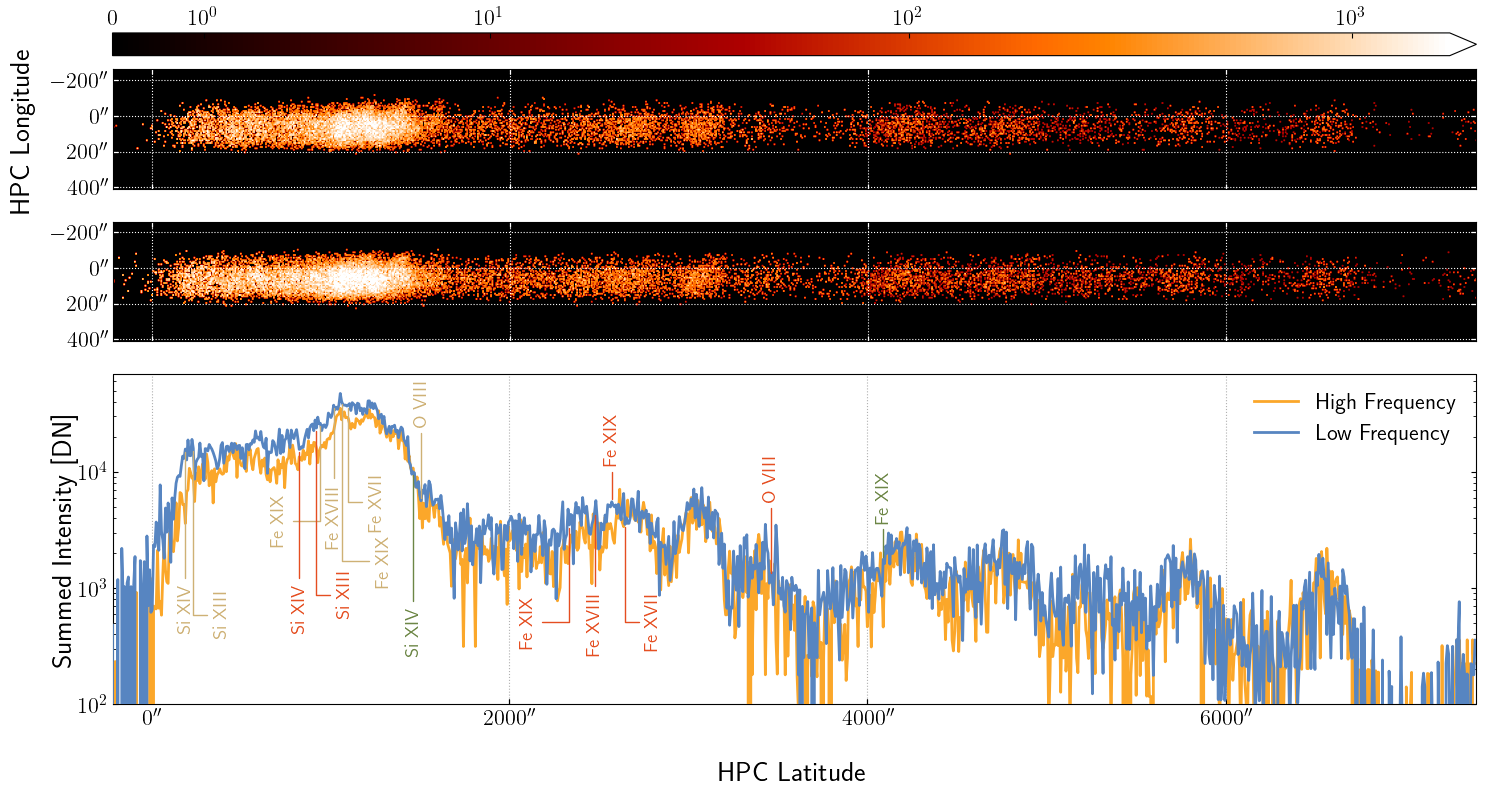

In [894]:
vmin,vmax = AsymmetricPercentileInterval(1,99.5).get_limits(total_overlappogram_lf_cutout.data)
norm = ImageNormalize(stretch=LogStretch(), vmin=vmin, vmax=vmax)

# Figure and Axes layout
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*(1,0.75))
axes = fig.subplot_mosaic(
    """
    A
    B
    C
    """,
    height_ratios=[1,1,2.5],
    per_subplot_kw={
        'A': {'projection': total_overlappogram_hf_cutout.wcs},
        'B': {'projection': total_overlappogram_lf_cutout.wcs},
        'C': {'projection': total_overlappogram_hf_cutout_spectra.wcs},
    }
)

# Plot Data
total_overlappogram_hf_cutout.plot(axes=axes['A'], norm=norm, cmap='hinodexrt')
total_overlappogram_lf_cutout.plot(axes=axes['B'], norm=norm, cmap='hinodexrt')
total_overlappogram_hf_cutout_spectra.plot(axes=axes['C'], color=frequency_palette[0], label='High Frequency')
total_overlappogram_lf_cutout_spectra.plot(axes=axes['C'], color=frequency_palette[1], label='Low Frequency')

# Ticks and ticklabels
color_lat_lon_axes(axes['A'], lon_color='w', lat_color='w')
color_lat_lon_axes(axes['B'], lon_color='w', lat_color='w')
axes['A'].coords[0].set_ticklabel(color='k')
axes['A'].coords[1].set_ticklabel_visible(False)
axes['A'].coords[0].set_auto_axislabel(False)
axes['A'].coords[1].set_axislabel_visibility_rule('always')
axes['B'].coords[0].set_ticklabel(color='k')
axes['B'].coords[1].set_ticklabel(color='k')
axes['B'].coords[1].set_ticklabel_visible(False)
axes['B'].coords[0].set_auto_axislabel(False)
axes['B'].coords[1].set_auto_axislabel(False)

# Grid
for ax in axes:
    for coord in axes[ax].coords:
        coord.grid(ls=':')

# Limits and labels
axes['A'].coords[1].set_axislabel('HPC Longitude', color='k', )
axes['C'].coords[1].set_axislabel('HPC Latitude', color='k')
axes['C'].set_ylabel('Summed Intensity [DN]')
axes['C'].set_xlim(0,total_overlappogram_hf_cutout_spectra.data.shape[0])
axes['C'].legend(loc=1)
axes['C'].set_yscale('log')
axes['C'].set_ylim(1e2, 7e4)

# Line labels
source_pt = SkyCoord(Tx=100*u.arcsec, Ty=-450*u.arcsec, frame=wcs_to_celestial_frame(overlappograms_hf[0].wcs))
wcs_list = [ol[:,sl[1],sl[2]].wcs for ol in overlappograms_lf[5:]]
annotate_kw = {
    'textcoords': 'offset points',
    'xytext': (0,-80),
    'arrowprops': dict(arrowstyle='-', lw=1, connectionstyle='angle,angleA=0,angleB=-90,rad=0'),
    'ha':'center',
    'va':'center',
    'rotation':90,
    'fontsize': plt.rcParams['xtick.labelsize']*0.85,
}
annotate_spectral_line(axes['C'], moxsi_lines[0], source_pt, wcs_list[:2], spectral_palette[1:3], total_overlappogram_lf_cutout_spectra.data, {**annotate_kw, 'xytext':(20,-70)})
annotate_spectral_line(axes['C'], moxsi_lines[10], source_pt, wcs_list[:2], spectral_palette[1:3], total_overlappogram_lf_cutout_spectra.data, annotate_kw)
annotate_spectral_line(axes['C'], moxsi_lines[-2], source_pt, wcs_list[:2], spectral_palette[1:3], total_overlappogram_lf_cutout_spectra.data, {**annotate_kw, 'xytext':(-30,-70)})
# Si XIV
annotate_spectral_line(axes['C'], moxsi_lines[-3], source_pt, wcs_list[:3], spectral_palette[1:4], total_overlappogram_lf_cutout_spectra.data, {**annotate_kw, 'xytext':(0,-115)})
# Fe XIX
annotate_spectral_line(axes['C'], moxsi_lines[-4], source_pt, wcs_list[:1], spectral_palette[1:2], total_overlappogram_lf_cutout_spectra.data, {**annotate_kw, 'xytext':(30,-115)})
annotate_spectral_line(axes['C'], moxsi_lines[-4], source_pt, wcs_list[1:3], spectral_palette[2:4], total_overlappogram_lf_cutout_spectra.data, {**annotate_kw, 'xytext':(0,45)})
# Si XIII
annotate_spectral_line(axes['C'], moxsi_lines[12], source_pt, wcs_list[:2], spectral_palette[1:3], total_overlappogram_lf_cutout_spectra.data, {**annotate_kw, 'xytext':(20,-120)})
# O VIII
annotate_spectral_line(axes['C'], moxsi_lines[4], source_pt, wcs_list[:2], spectral_palette[1:3], total_overlappogram_lf_cutout_spectra.data, {**annotate_kw, 'xytext':(0,70)})

plt.subplots_adjust(hspace=0.1, left=0.04167, right=1-0.04167, bottom=0, top=1)

fig.colorbar(
    axes['A'].get_images()[0],
    ax=[axes['A'],axes['B'],axes['C']],
    orientation='horizontal',
    location='top',
    fraction=0.06,
    extend='max',
    extendfrac=0.02,
    format=matplotlib.ticker.LogFormatterMathtext(base=10.0,),
    ticks=[0, 1, 10, 100, 1e3],
    pad=0.02,
    aspect=60
)

fig.savefig(figure_directory / 'simulated_moxsi_data_ar.pgf')

## DEM Inversion

In [913]:
import xarray
import tqdm
from sklearn.linear_model import ElasticNet, Ridge


def load_average_em_cube(data_dir, p, n_time=3600):
    # set up initial array
    m_dem_seq = sunpy.map.Map(sorted((data_dir / f'p{p}'/ 'dem').glob('m_*_t0.fits')), sequence=True)
    total_dem = np.zeros(m_dem_seq.as_array().shape)
    # set up temperature bins
    temperature_bin_edges = np.unique(np.array([m.meta['instrume'].split('_')[2].split('-') for m in m_dem_seq]).astype(float).flatten())
    temperature_bin_centers = (temperature_bin_edges[:-1] + temperature_bin_edges[1:])/2
    # iterate over all timesteps
    for i in tqdm.tqdm(range(n_time)):
        _seq = sunpy.map.Map(sorted((data_dir / f'p{p}'/ 'dem').glob(f'm_*_t{i}.fits')), sequence=True)
        total_dem += _seq.as_array()
    # return as xarray
    all_coords = sunpy.map.all_coordinates_from_map(m_dem_seq[0])
    return xarray.DataArray(
        total_dem/n_time,
        dims=['pixel_y', 'pixel_x', 'log_temperature'],
        coords={
            'log_temperature': temperature_bin_centers,
            'hpc_longitude': (['pixel_y', 'pixel_x'], all_coords.Tx.to_value('arcsec')),
            'hpc_latitude': (['pixel_y', 'pixel_x'], all_coords.Ty.to_value('arcsec')),
        },
        attrs={
            'bunit': 'cm-5',
            'p': p,
            **m_dem_seq[0].meta,
        },
        name='simulated_dem'
    )


def fit_spectra(response, spectra, scaling, model, plot_spectra_comparison=True,):
    """
    Fit spectra and visually assess goodness of fit.
    
    Parameters
    ----------
    """
    x_ = response.stack(pixel_logT=('pixel_x', 'log_temperature'))
    clf = model.fit(x_.values*scaling, spectra.values, )
    em_coefficients = xarray.DataArray(
        clf.coef_,
        dims=['pixel_logT'],
        coords={'pixel_logT': x_.pixel_logT},
    )*scaling
    recovered_spectra = x_.dot(em_coefficients, dims=['pixel_logT'])
    if plot_spectra_comparison:
        plt.figure(figsize=(25,5))
        spectra.plot(label='data')
        recovered_spectra.plot(label='recovered')
        plt.yscale('log')
        plt.legend()
        plt.show()
    print(model.score(x_.values*scaling, spectra.values))
    return em_coefficients.unstack(), recovered_spectra

Load all data needed for inversion

In [905]:
total_overlap_hf_rate = total_overlappogram_hf / (3600*u.s*1*u.pix)
total_overlap_lf_rate = total_overlappogram_lf / (3600*u.s*1*u.pix)
total_overlap_xa = xarray.Dataset({
    'hf': xarray.DataArray(
            total_overlap_hf_rate[0].data,
            dims=['pixel_y', 'pixel_detector'],
            attrs={
                'unit': total_overlap_hf_rate.unit.to_string(format='fits'),
            },
            name='simulated_moxsi_counts'
    ),
    'lf': xarray.DataArray(
            total_overlap_lf_rate[0].data,
            dims=['pixel_y', 'pixel_detector'],
            attrs={
                'unit': total_overlap_lf_rate.unit.to_string(format='fits'),
            },
            name='simulated_moxsi_counts'
    ),
})

In [906]:
response_matrix = xarray.open_dataarray('/Users/wtbarnes/Documents/projects/cubixss/moxsi-science-planning/sandbox/moxsi_response_matrix.nc')
response_matrix_total = response_matrix.sum(dim='spectral_order').rename({'pixel_fov': 'pixel_x'})
response_matrix_total = response_matrix_total.interp(
    log_temperature=em_true_hf.log_temperature,
    method='slinear',
    kwargs={'fill_value': 0.0,
            'bounds_error': False}
)

In [909]:
em_true_lf = load_average_em_cube(sphere_root_dir / 'pipeline' / 'data', 0.005, n_time=3600)
em_true_hf = load_average_em_cube(sphere_root_dir / 'pipeline' / 'data', 0.3, n_time=3600)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3600/3600 [05:13<00:00, 11.47it/s]


Work out a few bounding coordinates

In [911]:
total_extent = 2500 * u.arcsec
frame = wcs_to_celestial_frame(total_overlap_hf_rate.wcs)
bottom_left = SkyCoord(Tx=-total_extent/2, Ty=-total_extent/2, frame=frame)
top_right = SkyCoord(Tx=bottom_left.Tx+total_extent, Ty=bottom_left.Ty+total_extent, frame=frame)
spatial_fov = total_overlap_hf_rate[0,...].crop(bottom_left, top_right)

m_dem_sim = sunpy.map.Map(sphere_root_dir / 'pipeline' / 'data' / 'p0.3' / 'dem' / 'm_6.60-6.70_t1800.fits')
blc_core = SkyCoord(Tx=-50*u.arcsec, Ty=-575*u.arcsec, frame=m_dem_sim.coordinate_frame)
trc_core = SkyCoord(Tx=175*u.arcsec, Ty=-300*u.arcsec, frame=m_dem_sim.coordinate_frame)

i_y_min_dem_sim, i_x_min_dem_sim = m_dem_sim.wcs.world_to_array_index(blc_core)
i_y_max_dem_sim, i_x_max_dem_sim = m_dem_sim.wcs.world_to_array_index(trc_core)
i_y_max_dem_sim += 1
i_x_max_dem_sim += 1

iy_bl, ix_bl = spatial_fov.wcs.world_to_array_index(blc_core)
iy_tr, ix_tr = spatial_fov.wcs.world_to_array_index(trc_core)
i_fov_min = min(ix_bl, ix_tr)
i_fov_max = max(ix_bl, ix_tr) + 1  # inclusive of this pixel

iy_bl, ix_bl = total_overlap_hf_rate[0].wcs.world_to_array_index(blc_core)
iy_tr, ix_tr = total_overlap_hf_rate[0].wcs.world_to_array_index(trc_core)
i_y_min = min(iy_tr, iy_bl)
i_y_max = max(iy_tr, iy_bl) + 1  # inclusive of this pixel

Actually fit the spectra

In [914]:
ridge_model = Ridge(
    alpha=50,
    positive=True,
    max_iter=5000,
    fit_intercept=False
)
elasticnet_model = ElasticNet(
    positive=True,
    alpha=0.01,
    l1_ratio=1e-5,
    max_iter=5000,
    fit_intercept=False,
)
model_list = [
    ('Ridge', ridge_model),
    ('ElasticNet', elasticnet_model),
]

In [931]:
SCALING_CONSTANT = 1e30
spec_lf = total_overlap_xa['lf'][i_y_min:i_y_max,:,...].mean(dim='pixel_y',)
spec_hf = total_overlap_xa['hf'][i_y_min:i_y_max,:,...].mean(dim='pixel_y',)
resp_matrix = response_matrix_total[i_fov_min:i_fov_max,:,...]
recovered_ems = {}
recovered_spectra = {}
for name, model in model_list:
    em_recovered_lf, spec_recovered_lf = fit_spectra(resp_matrix, spec_lf, SCALING_CONSTANT, model, plot_spectra_comparison=False)
    em_recovered_hf, spec_recovered_hf = fit_spectra(resp_matrix, spec_hf, SCALING_CONSTANT, model, plot_spectra_comparison=False)
    recovered_ems[name] = {'HF': em_recovered_hf, 'LF': em_recovered_lf}
    recovered_spectra[name] = {'HF': spec_recovered_hf, 'LF': spec_recovered_lf}

0.9933581470616166
0.9919124978920301


/Users/wtbarnes/mambaforge/envs/spd-2023-moxsi-talk/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.779e-01, tolerance: 9.903e-03
  model = cd_fast.enet_coordinate_descent(


0.9936247822282134


/Users/wtbarnes/mambaforge/envs/spd-2023-moxsi-talk/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 5.939e-03
  model = cd_fast.enet_coordinate_descent(


0.9926057353706643


In [928]:
def get_t_edges_from_cube(cube):
    left_edge = cube.log_temperature - np.diff(cube.log_temperature)[0]/2
    right_edge = cube.log_temperature + np.diff(cube.log_temperature)[0]/2
    log_t_edges_true = np.append(left_edge, right_edge[-1])
    return 10**log_t_edges*u.K

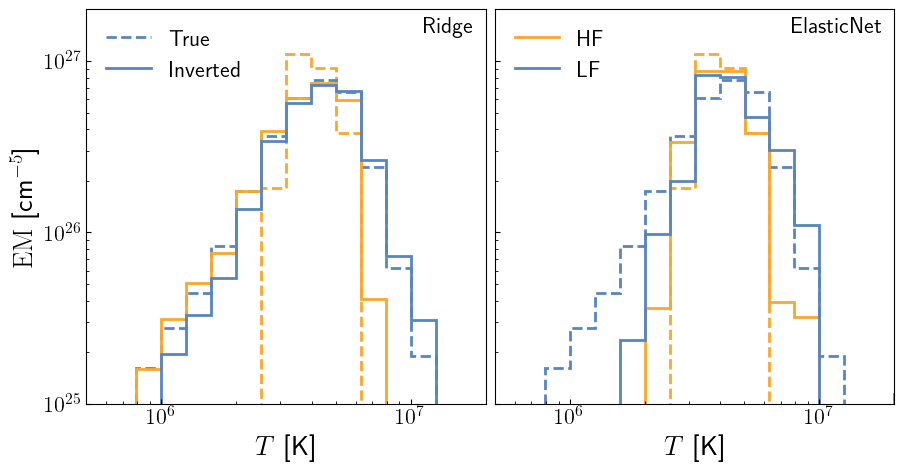

In [966]:
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*(0.6,1/2), layout='constrained')

axes = fig.subplot_mosaic(
    """
    AB
    """,
    sharex=True,
    sharey=True,
)

# Plot true EMs
em_true_hf_mean = em_true_hf[i_y_min_dem_sim:i_y_max_dem_sim, i_x_min_dem_sim:i_x_max_dem_sim, :].mean(dim=['pixel_y', 'pixel_x'])
em_true_lf_mean = em_true_lf[i_y_min_dem_sim:i_y_max_dem_sim, i_x_min_dem_sim:i_x_max_dem_sim, :].mean(dim=['pixel_y', 'pixel_x'])
for ax in axes:
    axes[ax].stairs(em_true_hf_mean, edges=get_t_edges_from_cube(em_true_hf).value,
              color=frequency_palette[0], ls='--', )
    axes[ax].stairs(em_true_lf_mean, edges=get_t_edges_from_cube(em_true_lf).value,
              color=frequency_palette[1], ls='--', label='True' if ax=='A' else None)

# Plot inverted EMS: Ridge
em_inv_hf_mean = recovered_ems['Ridge']['HF'].mean(dim='pixel_x')
em_inv_lf_mean = recovered_ems['Ridge']['LF'].mean(dim='pixel_x')
axes['A'].stairs(em_inv_hf_mean, edges=get_t_edges_from_cube(em_inv_hf_mean).value,
                 color=frequency_palette[0], ls='-')
axes['A'].stairs(em_inv_lf_mean, edges=get_t_edges_from_cube(em_inv_lf_mean).value,
                 color=frequency_palette[1], ls='-', label='Inverted')
# ElasticNet
em_inv_hf_mean = recovered_ems['ElasticNet']['HF'].mean(dim='pixel_x')
em_inv_lf_mean = recovered_ems['ElasticNet']['LF'].mean(dim='pixel_x')
axes['B'].stairs(em_inv_hf_mean, edges=get_t_edges_from_cube(em_inv_hf_mean).value,
                 color=frequency_palette[0], ls='-', label='HF')
axes['B'].stairs(em_inv_lf_mean, edges=get_t_edges_from_cube(em_inv_lf_mean).value,
                 color=frequency_palette[1], ls='-', label='LF')

# Limits and Labels
axes['A'].set_xscale('log')
axes['B'].set_yscale('log')
axes['A'].set_ylim(1e25, 2e27)
axes['A'].set_xlim(5e5, 2e7)
axes['A'].legend(loc=2)
axes['B'].legend(loc=2)
axes['A'].set_xlabel(r'$T$ [K]')
axes['B'].set_xlabel(r'$T$ [K]')
axes['A'].set_ylabel(r'$\mathrm{EM}$ [cm$^{-5}$]')

# Model labels
axes['A'].text(axes['A'].get_xlim()[1]*0.9, axes['A'].get_ylim()[1]*0.9, 'Ridge', va='top', ha='right', fontsize=plt.rcParams['legend.fontsize'])
axes['B'].text(axes['B'].get_xlim()[1]*0.9, axes['B'].get_ylim()[1]*0.9, 'ElasticNet', va='top', ha='right', fontsize=plt.rcParams['legend.fontsize'])

fig.savefig(figure_directory / 'inverted_moxsi_dem.pgf')

## Sandbox

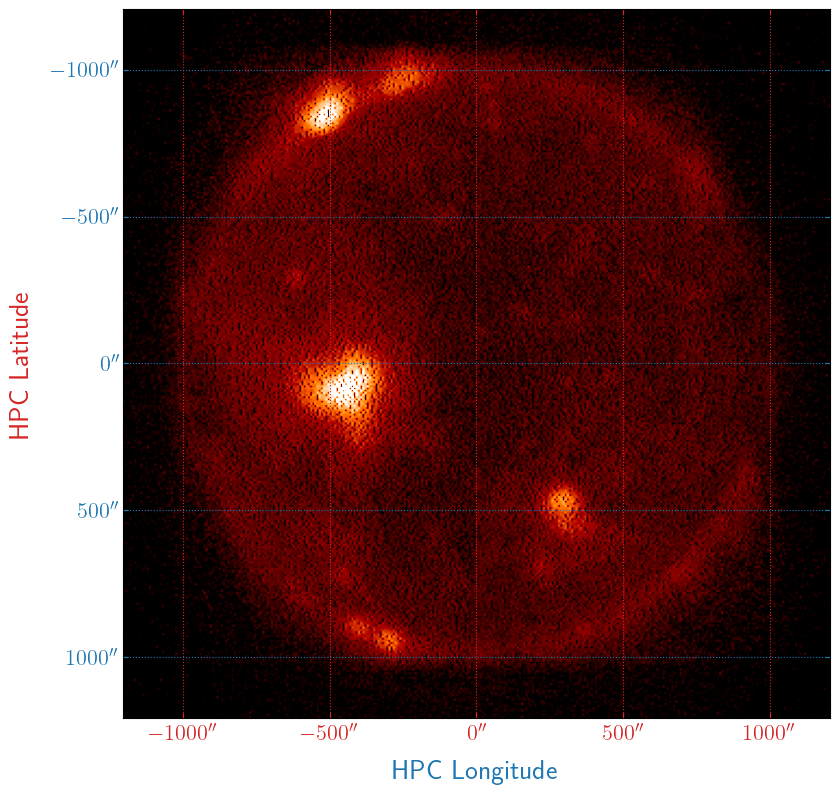

In [362]:
fig = plt.figure()
fg_crop = fg1[0].crop(blc, trc)
ax = fig.add_subplot(projection=fg_crop.wcs)
vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(fg_crop.data)
fg_crop.plot(axes=ax, norm=ImageNormalize(vmin=0, vmax=vmax, stretch=LogStretch()), cmap='hinodexrt',
             #interpolation='none'
            )
color_lat_lon_axes(ax,)
ax.coords[0].grid(alpha=1, ls=':')
ax.coords[1].grid(alpha=1, ls=':')
ax.coords[1].set_axislabel('HPC Latitude')
ax.coords[0].set_axislabel('HPC Longitude')

In [364]:
dispersed_image_dir = pathlib.Path('../pipeline/data/2020-11-09T18:00:00_sun_coronal_1992_feldman_ext_all/dispersed/')

In [375]:
all_overlappograms = [read_overlappogram(f) for f in  sorted(list(dispersed_image_dir.glob('dispersed_image-order*.fits')))]

In [376]:
total_overlappogram = stack_components(all_overlappograms, wcs_index=4)

<WCSAxes: >

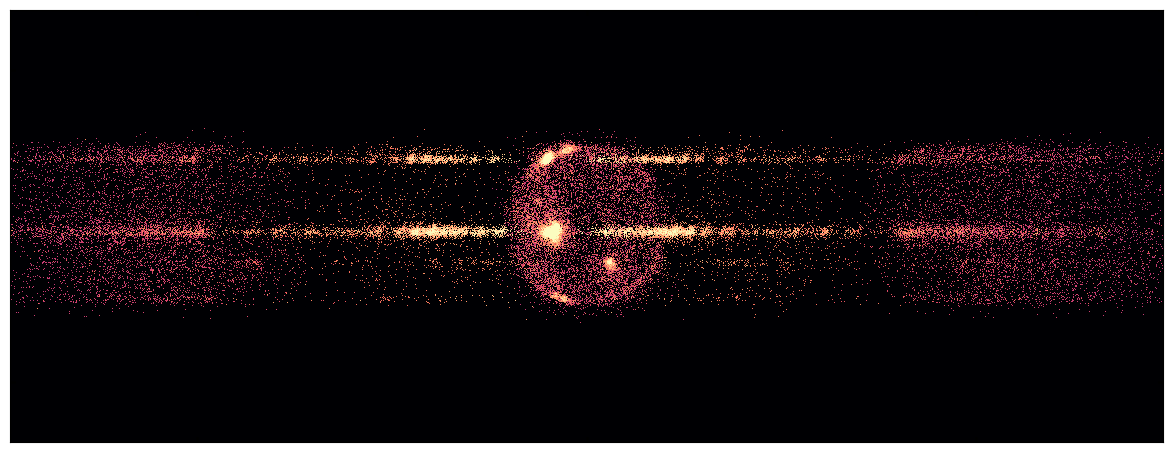

In [379]:
vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(total_overlappogram[0].data)
total_overlappogram[0].plot(norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()),
                            cmap='magma',
                            interpolation='none')

In [381]:
filtergram_image_dir = pathlib.Path('../pipeline/data/2020-11-09T18:00:00_sun_coronal_1992_feldman_ext_all/filtergram/')

In [382]:
all_filtergrams = [read_overlappogram(f) for f in  sorted(list(filtergram_image_dir.glob('filtergram_*-order0.fits')))]

In [386]:
total_filtergram = stack_components(all_filtergrams, wcs_index=1)

<WCSAxes: >

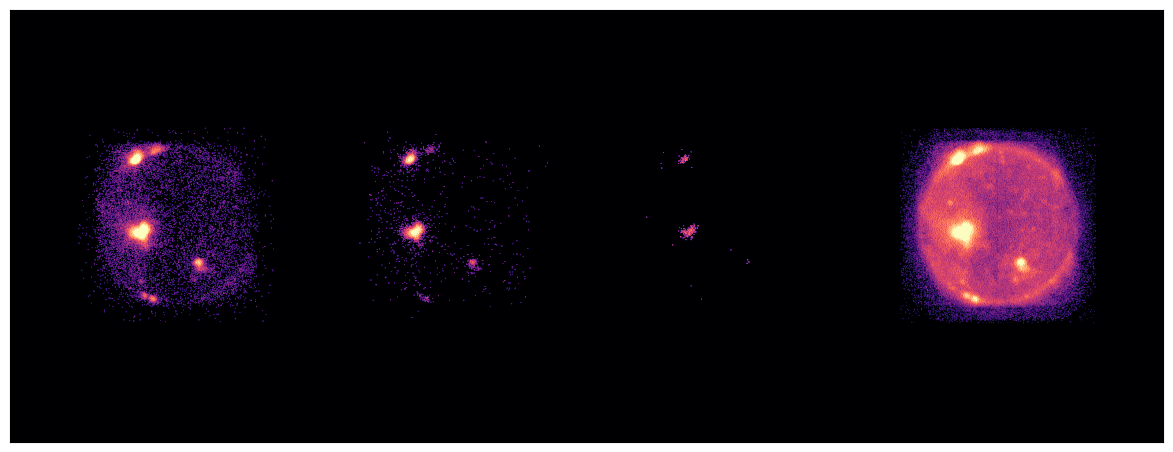

In [402]:
vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(total_filtergram[0].data)
total_filtergram[0].plot(norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()),
                            cmap='magma',)

In [506]:
0.1/3

0.03333333333333333

In [884]:
overlappograms_hf[5].wcs.world_to_pixel(source_pt, -total_overlappogram_hf.axis_world_coords(0)[0][::-1])

(array([-314.31091444, -313.31091444, -312.31091444, ...,  936.68908556,
         937.68908556,  938.68908556]),
 array([360.98648543, 360.98648543, 360.98648543, ..., 360.98648543,
        360.98648543, 360.98648543]),
 array([-1.253e+03, -1.252e+03, -1.251e+03, ..., -2.000e+00, -1.000e+00,
         0.000e+00]))

/Users/wtbarnes/mambaforge/envs/spd-2023-moxsi-talk/lib/python3.11/site-packages/ndcube/ndcube.py:942: RuntimeWarning: divide by zero encountered in divide
  return self.__mul__(1/value)
/Users/wtbarnes/mambaforge/envs/spd-2023-moxsi-talk/lib/python3.11/site-packages/ndcube/ndcube.py:932: RuntimeWarning: invalid value encountered in multiply
  new_data = self.data * value


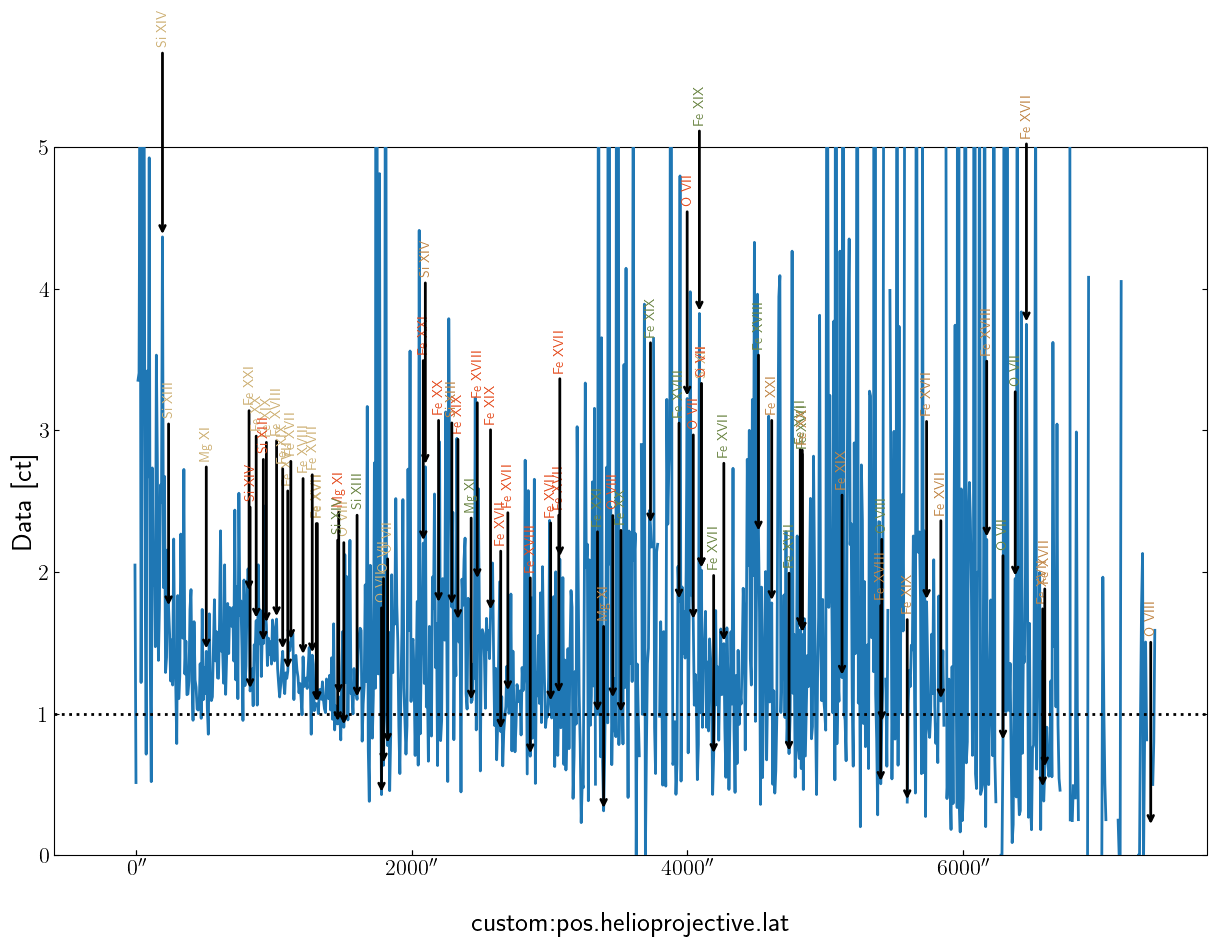

In [819]:
ratio = total_overlappogram_lf_cutout_spectra / total_overlappogram_hf_cutout_spectra.data
fig = plt.figure()
ax  = fig.add_subplot(projection=ratio.wcs)
ratio.plot(axes=ax)
for ol,color in zip(overlappograms_lf[5:],spectral_palette[1:]):
    for line in moxsi_lines:
        _,_,ix = ol[:, sl[1], sl[2]].wcs.world_to_array_index(
             SkyCoord(Tx=100*u.arcsec, Ty=-450*u.arcsec, frame=wcs_to_celestial_frame(overlappograms_hf[0].wcs)),
            line['wavelength'])
        if ix < ratio.data.shape[0]:
            ax.annotate(line['ion name'], xy=(ix, ratio.data[ix]), xytext=(0,150),
                        arrowprops=dict(arrowstyle='->'),
                        color=color,
                        rotation=90,
                        textcoords='offset points',
                        ha='center', va='center')
plt.ylim(0,5)
plt.axhline(y=1, color='k', ls=':')

In [ ]:
for i,(di,color) in enumerate(zip(overlappograms_lf[5:],spectral_palette[1:])):
    di_spectra = di[sl].rebin(di[sl].data.shape[:1]+(1,), operation=np.sum)[0,:]
    for group in moxsi_line_groups.groups:
        # Compute average position of all lines in group
        ix_mean = []
        y_mean = []
        _,_,ix_mean = di[:, sl[1], sl[2]].wcs.world_to_array_index(annot_pt, group['wavelength'].mean())
        if ix_mean>total_overlappogram_lf_cutout_spectra.data.shape[0]-1:
            continue
        #if di_spectra.data[ix] / total_dispersed_image_cutout_spectra.data[ix] < line_strength_thresh:
        #    continue
        y_mean = total_overlappogram_lf_cutout_spectra.data[ix_mean]
        ann = axes['C'].annotate(group[0]['ion name'], xy=(ix_mean, y_mean*1.5),
                                 rotation=90, color=color, va='bottom', ha='center', 
                                 fontsize=plt.rcParams['xtick.labelsize']*0.75)
        for line in group:
            _,_,ix = di[:, sl[1], sl[2]].wcs.world_to_array_index(annot_pt, line['wavelength'])
            if ix>total_overlappogram_lf_cutout_spectra.data.shape[0]-1:
                continue
            if di_spectra.data[ix] / total_overlappogram_lf_cutout_spectra.data[ix] < line_strength_thresh:
                continue
            axes['C'].annotate(
                '', #line['ion name'],
                xy=(ix, total_overlappogram_lf_cutout_spectra.data[ix]),
                xytext=ann.xy,
                textcoords='data',
                arrowprops=dict(arrowstyle='-', color=color, ls='-',
                                connectionstyle='angle,angleA=-90,angleB=180,rad=0', lw=1),
                ha='center',
                va='center',
                rotation=90,
            )

In [ ]:
    cropped_cube.plot(
        axes=ax,
        norm=norm,
        data_unit='ct',
        cmap='viridis',
        interpolation='none'
    )
    color_lat_lon_axes(ax)
    ax.coords[1].set_axislabel('HPC Latitude' if i>0 else ' ')
    ax.coords[0].set_axislabel('HPC Longitude' if i>0 else ' ')
    ax.coords[0].set_ticks(([-500, 0, 500]*u.arcsec).to('deg'))
    ax.coords[1].set_ticks(([-1000, 0, 1000]*u.arcsec).to('deg'))
    ax.coords[0].set_major_formatter('s')
    ax.coords[1].set_major_formatter('s')
    if i == 0:
        ax.coords[1].set_ticklabel_visible(False)
    ax.text(10, cropped_cube.data.shape[0]-10, label,
            verticalalignment='top',
            horizontalalignment='left',
            color='w')
    axes.append(ax)

#ax = None
#for ol, color, label in zip([overlappograms_hf, overlappograms_lf], frequency_palette, labels):
#    ol_stacked = stack_components(ol)
#    total_rebin = ol_stacked[0].rebin((ol_stacked[0].data.shape[0], 1),operation=np.sum)[0]
#    if ax is None:
#        ax = fig.add_subplot(3,1,3,projection=total_rebin)
#    total_rebin.plot(axes=ax, ls='-', data_unit='ct', label=label, color=color)
#
#ax.set_yscale('log')
#ax.set_ylim(10, 3e5)
#ax.set_xlim(0, 2000)
#ax.set_ylabel('Summed Counts [DN]')
#ax.coords[1].set_axislabel('HPC Latitude')
#ax.legend(frameon=False)


In [828]:
moxsi_lines[['ion name', 'wavelength']]

<QTable length=19>
ion name     wavelength    
              Angstrom     
  str9        float64      
-------- ------------------
 Fe XVII 15.012999534606934
 Fe XVII 17.051000595092773
 Fe XVII  17.09600067138672
 Fe XVII  16.77560043334961
  O VIII 18.967100143432617
   O VII 21.601499557495117
 Fe XVII  15.26200008392334
   O VII 22.097700119018555
  Si XII 44.160301208496094
Fe XVIII  16.07200050354004
Fe XVIII 14.208800315856934
   Mg XI  9.314299583435059
 Si XIII  6.647900104522705
  Fe XXI 12.281999588012695
   Fe XX  12.82699966430664
  Fe XIX 14.668999671936035
  Si XIV 6.1803998947143555
  Fe XIX 13.524900436401367
   O VII 21.803600311279297